In [1]:
import os, cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from skimage.feature import hog
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Configuration
IMG_SIZE = (96, 96)  
DATA_ROOT = '/kaggle/input/doggai/dogs-vs-cats (1)'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train', 'train')

In [3]:
# Feature Extraction Function (HOG)
def extract_hog_features_from_path(image_path, img_size):
    try:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"DEBUG: Failed to read {image_path}")
            return None
        img = cv2.resize(img, img_size)

        # Updated HOG parameters
        features = hog(img, orientations=11, pixels_per_cell=(8, 8),
                       cells_per_block=(3, 3), block_norm='L2-Hys',
                       transform_sqrt=True)
        return features
    except Exception as e:
        print(f"DEBUG: Error reading {image_path}: {e}")
        return None

In [4]:
# Data Loader
def load_dataset(data_dir, img_size, feature_extractor_func, limit_images=None):
    features, labels = [], []
    if not os.path.exists(data_dir):
        print(f"ERROR: Directory not found: {data_dir}")
        return np.array(features), np.array(labels)

    image_files = [f for f in os.listdir(data_dir)
                   if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if limit_images:
        image_files = image_files[:limit_images]

    for image_name in tqdm(image_files, desc="Extracting features"):
        image_path = os.path.join(data_dir, image_name)

        if image_name.startswith('cat'):
            label = 0
        elif image_name.startswith('dog'):
            label = 1
        else:
            continue  

        features_vec = feature_extractor_func(image_path, img_size)
        if features_vec is not None:
            features.append(features_vec)
            labels.append(label)

    print(f"Loaded {len(features)} samples. Cats: {labels.count(0)}, Dogs: {labels.count(1)}")
    return np.array(features), np.array(labels)

In [5]:
# Load Dataset
print("Loading and extracting features...")
X, y = load_dataset(TRAIN_DIR, IMG_SIZE, extract_hog_features_from_path, limit_images=8000)

if X.size == 0:
    print("ERROR: No features extracted. Check dataset path.")
    exit()

Loading and extracting features...


Extracting features: 100%|██████████| 8000/8000 [01:53<00:00, 70.35it/s]


Loaded 8000 samples. Cats: 3985, Dogs: 4015


In [6]:
# PCA: Dimensionality Reduction
print("Applying PCA...")
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X)
print(f"PCA reduced feature shape: {X_pca.shape}")

Applying PCA...
PCA reduced feature shape: (8000, 1208)


In [7]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(
    X_pca, y, test_size=0.25, random_state=42, stratify=y)

print(f"Train size: {len(X_train)}, Validation size: {len(X_val)}")

Train size: 6000, Validation size: 2000


In [8]:
# Grid Search for SVM (RBF Kernel)
print("Running GridSearchCV for SVM...")

param_grid = {
    'C': [1, 10],
    'gamma': [0.01, 0.1]
}

svm_model = SVC(kernel='rbf', random_state=42)
grid_search = GridSearchCV(svm_model, param_grid, cv=3, n_jobs=-1, verbose=0, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

Running GridSearchCV for SVM...
Best Parameters: {'C': 1, 'gamma': 0.01}
Best Cross-Validation Accuracy: 0.7433



--- Validation Performance ---
Validation Accuracy: 0.7555

Classification Report:
              precision    recall  f1-score   support

         Cat       0.76      0.75      0.75       996
         Dog       0.75      0.76      0.76      1004

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



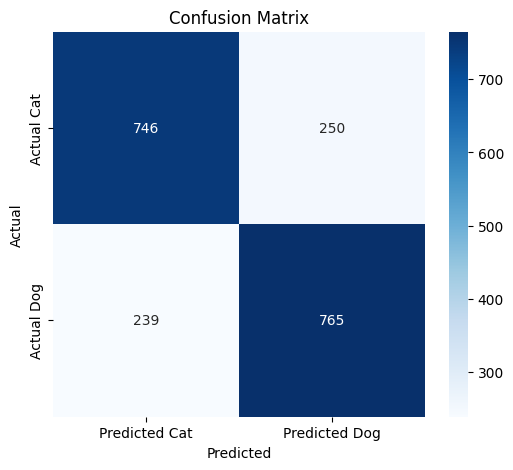

In [9]:
# Evaluation on Validation Set
y_pred = best_model.predict(X_val)

print("\n--- Validation Performance ---")
acc = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred, target_names=['Cat', 'Dog']))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Predicted Cat', 'Predicted Dog'],
            yticklabels=['Actual Cat', 'Actual Dog'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [10]:
    print(X_pca.shape, len(y))


(8000, 1208) 8000



🧠 Batch Prediction System
📸 Predicting predefined images...

Processing: istockphoto-1443562748-612x612.jpg


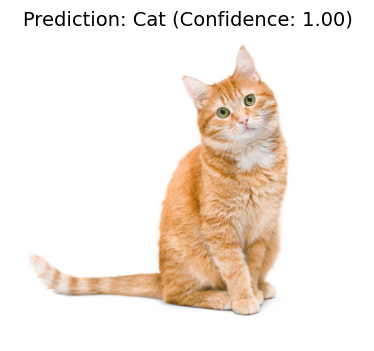

✅ Prediction: Cat
🔢 Confidence: 1.00

Processing: p07ryyyj.jpg


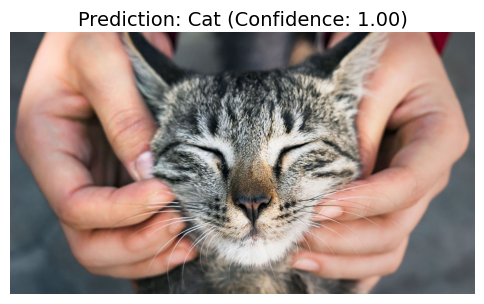

✅ Prediction: Cat
🔢 Confidence: 1.00

Processing: dog-breeds-for-kids-pug-dog-1200x800.jpg


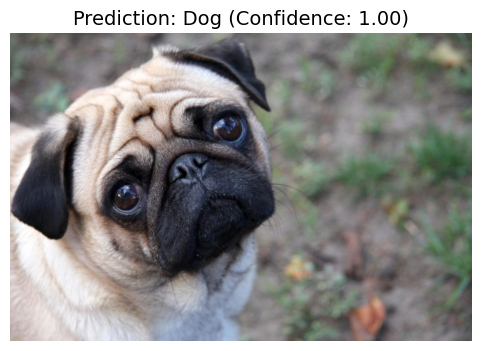

✅ Prediction: Dog
🔢 Confidence: 1.00



In [11]:
import os
import cv2
import matplotlib.pyplot as plt

# ✅ Use your actual feature extractor
def extract_features_for_prediction(image_path, img_size):
    return extract_hog_features_from_path(image_path, img_size)

# ✅ Updated Prediction Function (No Scaler Used)
def predict_user_image(model, pca_model, image_path, img_size, feature_extractor_func):
    """Predicts class and confidence for a given image using HOG + PCA + SVM"""
    extracted_features = feature_extractor_func(image_path, img_size)

    if extracted_features is not None:
        try:
            features_reshaped = extracted_features.reshape(1, -1)
            features_pca = pca_model.transform(features_reshaped)
            prediction = model.predict(features_pca)[0]

            if hasattr(model, 'predict_proba'):
                confidence = max(model.predict_proba(features_pca)[0])
            else:
                confidence = 1.0

            label = "Cat" if prediction == 0 else "Dog"
            return label, confidence
        except Exception as e:
            return f"Error during prediction: {e}", 0.0
    else:
        return "Error: Could not process image or extract features.", 0.0

# ✅ Define image paths (adjust if needed)
test_image_paths = [
    "/kaggle/input/dog-cat-test/istockphoto-1443562748-612x612.jpg",
    "/kaggle/input/dog-cat-test/p07ryyyj.jpg",
    "/kaggle/input/dog-cat-test/dog-breeds-for-kids-pug-dog-1200x800.jpg"
]

# ✅ Batch Prediction Loop
print("\n" + "=" * 60)
print("🧠 Batch Prediction System")
print("📸 Predicting predefined images...\n")

for image_path in test_image_paths:
    print(f"Processing: {os.path.basename(image_path)}")
    
    if not os.path.exists(image_path):
        print(f"❌ File not found: {image_path}\n")
        continue

    try:
        # Read and convert image
        img_bgr = cv2.imread(image_path)
        if img_bgr is None:
            print(f"❌ Could not read image file: {image_path}\n")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # ✅ Predict using corrected logic
        prediction, confidence = predict_user_image(
            best_model, pca, image_path, IMG_SIZE, extract_features_for_prediction
        )

        # Show image and prediction
        plt.figure(figsize=(6, 4))
        plt.imshow(img_rgb)
        plt.title(f"Prediction: {prediction} (Confidence: {confidence:.2f})", fontsize=14)
        plt.axis('off')
        plt.show()

        print(f"✅ Prediction: {prediction}")
        print(f"🔢 Confidence: {confidence:.2f}\n")

    except Exception as e:
        print(f"⚠️ Error processing {image_path}: {e}\n")
